# Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент: | Глушатов И.С. |
|---------|--------|
| Группа:  | М8О-307Б-19      |

In [1]:
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import numpy as np
np.random.seed(0)
import random
import pylab
import pickle

Загружаем датасет:

In [2]:
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [4]:
data.shape

(42000, 784)

In [5]:
TrainData, TestData, TrainLabels, TestLabels = train_test_split(
    data, labels, test_size=0.3, shuffle=True
)

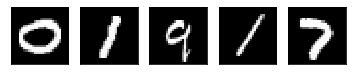

In [6]:
fig = pylab.figure()

for i in range(0, 5):
    ax = fig.add_subplot(1, 5, i + 1)
    pylab.imshow(TrainData[i].reshape(28,28), cmap='gray', interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])

pylab.show()

### Реализация классов для построения нейросети

In [7]:
class Layer:
    def __init__(self, nin, nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db
        
    def __str__(self):
        return f"{self.W}\n{self.b}"

class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    
    def backward(self, dy):
        return (1.0-self.y**2)*dy

class ReLU:
    def forward(self,x):
        y = np.maximum(0, x)
        self.x = x
        self.y = y
        return y
    
    def backward(self,dy):
        self.x[self.x<=0] = 0
        self.x[self.x>0] = 1
        return self.x * dy

class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / self.p
    
class MSE:
    def forward(self, p, y):
        self.p = p
        self.y = y
        self.k = np.zeros_like(p)
        self.k[np.arange(len(self.y)), y] = 1
        div = np.square(p - self.k).sum(axis=1)
        return div.mean()
    
    def backward(self,loss):
        return (2*(self.p - self.k)) / self.k.shape[1]
    
class Net:
    def __init__(self, loss_function = CrossEntropyLoss()):
        self.layers = []
        self.loss_function = loss_function
    
    def add(self, l):
        if type(l) is list:
            self.layers += l
        else: 
            self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
                
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss_function.forward(p,y)
        pred = np.argmax(p,axis=1)
        acc = (pred==y).mean()
        return l, acc
    
    def get_confusion_matrix(self, TrainData, TrainLabels, betta = 1.0):
        betta = max(0.0, min(betta, 1.0))
        n = 0
        
        for l in self.layers:
            if 'update' in l.__dir__():
                n = l.b.shape[1]
        
        matrix = np.zeros((n, n))
        
        for i in range(0,len(TrainData)):
            xb = TrainData[i]
            yb = TrainLabels[i]
            p = self.forward(xb)
            pred = np.argmax(p)
            matrix[pred][yb] += 1
        
        precisions = matrix.diagonal() / matrix.sum(axis=1)
        recall = matrix.diagonal() / matrix.sum(axis=0)
        
        FMeasure = (betta**2 + 1) * (precisions * recall) \
                     / ((betta**2) * precisions + recall)

        return matrix, precisions, recall, FMeasure
        
    def train_epoch(self, TrainData, TrainLabels, batch_size=1, lr=0.0000001):
        def unison_shuffled_copies(a, b):
            assert len(a) == len(b)
            p = np.random.permutation(len(a))
            return a[p], b[p]
        
        TrainData, TrainLabels = unison_shuffled_copies(TrainData, TrainLabels)
        
        for i in range(0,len(TrainData),batch_size):
            xb = TrainData[i:i+batch_size]
            yb = TrainLabels[i:i+batch_size]

            p = self.forward(xb)
            l = self.loss_function.forward(p,yb)
            dp = self.loss_function.backward(l)
            dx = self.backward(dp)
            net.update(lr)
            
    def train(self, count_of_epoch, TrainData, TrainLabels, batch_size=1, lr=0.0000001, print_step=False):
        for i in range(count_of_epoch):
            self.train_epoch(TrainData, TrainLabels, batch_size, lr)
            if print_step:
                print("[{}] Intermediate loss={}, accuracy={}: ".format(i+1, *self.get_loss_acc(TrainData, TrainLabels)))
            
    def train_and_plot(self, count_of_epoch, TrainData, TrainLabels, TestData, TestLabels, batch_size=1, lr=0.0000001, print_step=False):
        result = []
        
        result.append((0, net.get_loss_acc(TrainData, TrainLabels)[1], net.get_loss_acc(TestData, TestLabels)[1]))
        
        for i in range(count_of_epoch):
            self.train_epoch(TrainData, TrainLabels, batch_size, lr)
            if print_step:
                print("[{}] Intermediate loss={}, accuracy={}: ".format(i+1, *self.get_loss_acc(TrainData, TrainLabels)))
            result.append((i+1, net.get_loss_acc(TrainData, TrainLabels)[1], net.get_loss_acc(TestData, TestLabels)[1]))
        
        print("Final loss={}, accuracy={}: ".format(*self.get_loss_acc(TrainData, TrainLabels)))
        print("Test loss={}, accuracy={}: ".format(*self.get_loss_acc(TestData, TestLabels)))
        
        r = np.array(result)
        fig, axs = plt.subplots(1, 2, figsize=(9, 3))
        axs[0].plot(r[:, 0], r[0:, 1:2], "g-", r[:, 0], r[0:, 2:3], "k--")
        caxes = axs[1].matshow(self.get_confusion_matrix(TestData, TestLabels)[0])
        fig.colorbar(caxes)
        fig.suptitle('Result')
        plt.show()
        
        return result

**Однослойный перцептрон, классифицирующий датасет MNIST с точностью >85%**

In [8]:
net = Net()
net.add(Layer(784, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(TrainData, TrainLabels)))

net.train(40, TrainData, TrainLabels, 2) #30 epochs 2 butches
        
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(TrainData, TrainLabels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(TestData, TestLabels)))

Initial loss=127.67017960890674, accuracy=0.05996598639455782: 
Final loss=4.123722160591145, accuracy=0.8608163265306122: 
Test loss=4.740499208672526, accuracy=0.8534126984126984: 


**Многослойный перцептрон, классифицирующий датасет MNIST с точностью >85%**

В качестве передаточной функции выступает ReLU

In [9]:
net = Net()
net.add(Layer(784, 130))
net.add(ReLU())
net.add(Layer(130, 10))
net.add(Softmax())

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_acc(TrainData, TrainLabels)))

net.train(10, TrainData, TrainLabels, 20, 0.0001)
        
print("Final loss={}, accuracy={}: ".format(*net.get_loss_acc(TrainData, TrainLabels)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_acc(TestData, TestLabels)))

Initial loss=101.34615274018326, accuracy=0.11003401360544218: 
Final loss=0.1207123434923639, accuracy=0.9761904761904762: 
Test loss=0.6743377101893254, accuracy=0.926031746031746: 


**Сравнение гиперпараметров: число нейронов в промежуточных слоях**

Final loss=0.019587703495329706, accuracy=0.9936054421768707: 
Test loss=0.4323421694347418, accuracy=0.9464285714285714: 


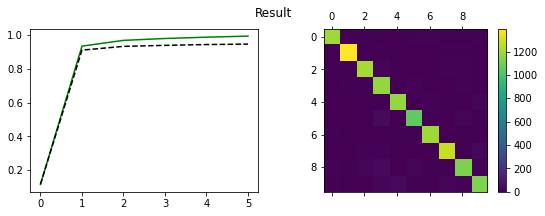

Final loss=0.13400984310165331, accuracy=0.9585374149659864: 
Test loss=0.35257554679932496, accuracy=0.9244444444444444: 


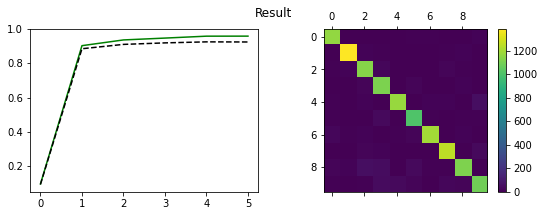

Final loss=0.40918573526977564, accuracy=0.8860544217687075: 
Test loss=0.48856475157768425, accuracy=0.8745238095238095: 


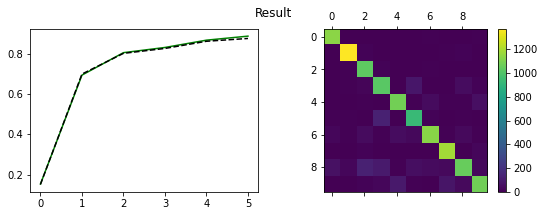

In [10]:
net = Net()
net.add([Layer(784, 392), ReLU(), Layer(392, 10), Softmax()])
r = net.train_and_plot(5, TrainData, TrainLabels, TestData, TestLabels, 4, 0.0001)

net = Net()
net.add([Layer(784, 130), ReLU(), Layer(130, 10), Softmax()])
r = net.train_and_plot(5, TrainData, TrainLabels, TestData, TestLabels, 4, 0.0001)

net = Net()
net.add([Layer(784, 40), ReLU(), Layer(40, 10), Softmax()])
r = net.train_and_plot(5, TrainData, TrainLabels, TestData, TestLabels, 4, 0.0001)

Из полученных данных можно сделать вывод, что число нейронов в промежуточных слоях прямо пропорционально увеличивает вероятность правильного ответа

**Сравнение гиперпараметров: передаточная функция**

Сравнение передаточных функций гиперболического тангенса и ReLU на многослойном перцептроне

Final loss=0.2883769138445279, accuracy=0.9251360544217687: 
Test loss=0.3130402074214567, accuracy=0.9167460317460318: 


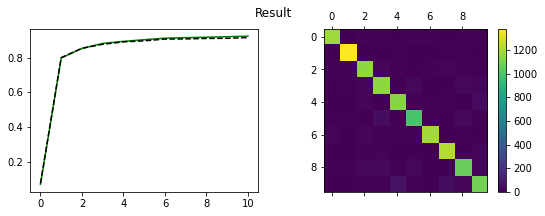

Final loss=0.07806611667113321, accuracy=0.9767687074829932: 
Test loss=0.19444760028481184, accuracy=0.9488095238095238: 


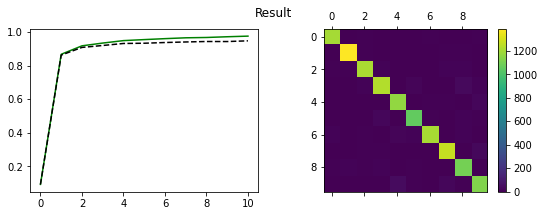

In [11]:
net = Net()
net.add([Layer(784, 130), Tanh(), Layer(130, 40), Tanh(), Layer(40, 10), Softmax()])
r = net.train_and_plot(10, TrainData, TrainLabels, TestData, TestLabels, 20, 0.001)

net = Net()
net.add([Layer(784, 130), ReLU(), Layer(130, 40), ReLU(), Layer(40, 10), Softmax()])
r = net.train_and_plot(10, TrainData, TrainLabels, TestData, TestLabels, 20, 0.001)

В данном случае ReLU работает немного лучше, однако помимо этого стоит сказать, что сеть с ReLU в качестве передаточной функции намного быстрее обучается.

**Сравнение гиперпараметров: функция потерь**

Сравнение кросс-энтропии и среднеквадратической функций потерь на многослойном перцептроне с передаточной функцией гиперболическим тангенсом

Final loss=0.1631756154187486, accuracy=0.954421768707483: 
Test loss=0.2113110315751427, accuracy=0.9372222222222222: 


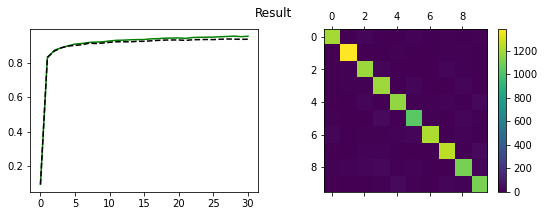

Final loss=0.15424020757026308, accuracy=0.9120408163265306: 
Test loss=0.18013796818764208, accuracy=0.8881746031746032: 


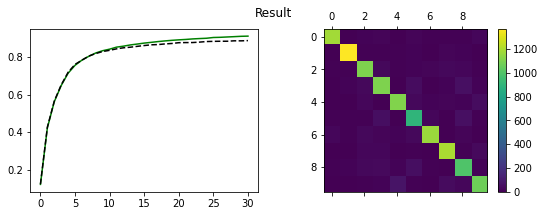

In [12]:
net = Net(CrossEntropyLoss())
net.add([Layer(784, 130), Tanh(), Layer(130, 10), Softmax()])
r = net.train_and_plot(30, TrainData, TrainLabels, TestData, TestLabels, 2, 0.0001)

net = Net(MSE())
net.add([Layer(784, 130), Tanh(), Layer(130, 10), Softmax()])
r = net.train_and_plot(30, TrainData, TrainLabels, TestData, TestLabels, 2, 0.0001)

По результатам можно сделать вывод, что использование Cross Entropy Loss гарантирует лучшую сходимость, в отличие от MSE. Причем серия опытов (не представленная в конечном результате) показывает, что MSE на однослойном перцептроне работает очень плохо

### Fashion MNIST

In [70]:
from utils import mnist_reader
TrainData, TrainLabels = mnist_reader.load_mnist('data/fashion', kind='train')
TestData, TestLabels = mnist_reader.load_mnist('data/fashion', kind='t10k')

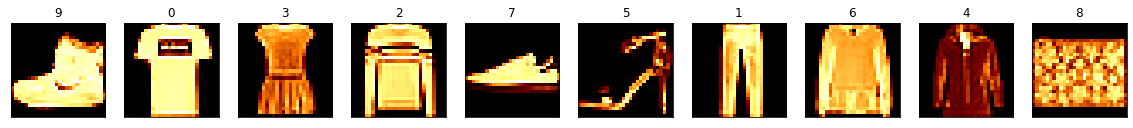

In [54]:
fig = pylab.figure(figsize=(20, 5))

checked = []
k = 1
for i in range(0, len(TrainData)):
    if TrainLabels[i] not in checked:
        ax = fig.add_subplot(1, 10, k)
        k += 1
        pylab.imshow(TrainData[i].reshape(28,28), cmap='afmhot')
        plt.title(TrainLabels[i])
        ax.set_xticks([])
        ax.set_yticks([])
        checked.append(TrainLabels[i])

pylab.show()

[1] Intermediate loss=0.6079950658625527, accuracy=0.7789166666666667: 
[2] Intermediate loss=0.49753223771521177, accuracy=0.8155: 
[3] Intermediate loss=0.4673394661641362, accuracy=0.8282166666666667: 
[4] Intermediate loss=0.4730640536625426, accuracy=0.83145: 
[5] Intermediate loss=0.43635297809740464, accuracy=0.8440166666666666: 
[6] Intermediate loss=0.43217818834801697, accuracy=0.8435333333333334: 
[7] Intermediate loss=0.3991515250678924, accuracy=0.8522833333333333: 
[8] Intermediate loss=0.4007993142253739, accuracy=0.8522833333333333: 
[9] Intermediate loss=0.39597494945614237, accuracy=0.8535666666666667: 
[10] Intermediate loss=0.3775552253720718, accuracy=0.8611666666666666: 
[11] Intermediate loss=0.36562703153779574, accuracy=0.8631: 
[12] Intermediate loss=0.37100063357307334, accuracy=0.8606333333333334: 
[13] Intermediate loss=0.35339195805371165, accuracy=0.8666666666666667: 
[14] Intermediate loss=0.36593896974210915, accuracy=0.8611833333333333: 
[15] Intermedi

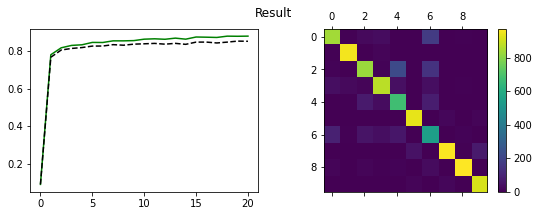

In [20]:
net = Net()
net.add([Layer(784, 100), ReLU(), Layer(100, 100), ReLU(),Layer(100, 10), Softmax()])
r = net.train_and_plot(20, TrainData, TrainLabels, TestData, TestLabels, 4, 0.0001, print_step=True)

Анализируя матрицу неточности, можно увидеть, что несмотря на достаточный показатель точности в 85%, футболки, рубашки и свитеры нейросети не всегда удается отличать друг от друга. Рубашку в принципе много с чем путают, из-за чего диагональный элемент не так явно выражен. Различная обувь распознается лучше, но все равно проскакивают маленькие огрехи.

In [66]:
[m, p, re, f] = net.get_confusion_matrix(TestData, TestLabels)

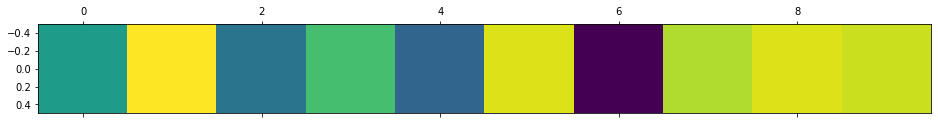

In [69]:
plt.matshow([f])
plt.show()

Представленная F-мера подтверждает плохую классификацию верхней одежды (классы 0, 2, 4, 6), в особенности рубашки. Наоборот, брюки определяются точнее всего, так как из представленных классов никакие из остальных не схожи.